# Understanding Hired Rides in NYC

_[Project prompt](https://docs.google.com/document/d/1tGcX2qzS2GoaN5zFeD5DVJxqDmoQdmMs7QncZwFCEqU/edit#)_

_This scaffolding notebook may be used to help setup your final project. It's totally optional whether you make use of this or not._

_If you do use this notebook, everything provided is optional as well - you may remove or add prose and code as you wish._

_Anything in italics (prose) or comments (in code) is meant to provide you with guidance. **Remove the italic lines and provided comments** before submitting the project, if you choose to use this scaffolding. We don't need the guidance when grading._

_All code should be consider "pseudo-code" - not functional by itself, and only a suggestion at the approach._

## Requirements

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project._

* Code clarity: make sure the code conforms to:
    * [ ] [PEP 8](https://peps.python.org/pep-0008/) - You might find [this resource](https://realpython.com/python-pep8/) helpful as well as [this](https://github.com/dnanhkhoa/nb_black) or [this](https://jupyterlab-code-formatter.readthedocs.io/en/latest/) tool
    * [ ] [PEP 257](https://peps.python.org/pep-0257/)
    * [ ] Break each task down into logical functions
* The following files are submitted for the project (see the project's GDoc for more details):
    * [ ] `README.md`
    * [ ] `requirements.txt`
    * [ ] `.gitignore`
    * [ ] `schema.sql`
    * [ ] 6 query files (using the `.sql` extension), appropriately named for the purpose of the query
    * [x] Jupyter Notebook containing the project (this file!)
* [x] You can edit this cell and add a `x` inside the `[ ]` like this task to denote a completed task

## Project Setup

In [34]:
# all import statements needed for the project, for example:
import sys

import seaborn as sns
import numpy as np
import math
import os
import bs4
import matplotlib.pyplot as plt
import pandas as pd
import requests
import sqlalchemy as db
from os.path import exists

In [36]:
# any general notebook setup, like log formatting

In [37]:
# any constants you might need, for example:

TAXI_URL = "https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page"
# add other constants to refer to any local data, e.g. uber & weather
UBER_CSV = "taxi_csv/uber_rides_sample.csv"

NEW_YORK_BOX_COORDS = ((40.560445, -74.242330), (40.908524, -73.717047))

DATABASE_URL = "sqlite:///project.db"
DATABASE_SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

## Part 1: Data Preprocessing

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Define a function that calculates the distance between two coordinates in kilometers that **only uses the `math` module** from the standard library
* [ ] Write at least one unit test that tests this distance calculation function. 
* Taxi data:
    * [ ] Use `requests`, BeautifulSoup (`bs4`), and `pandas` to programmatically download the required CSV files & load into memory.
    * [ ] Clean the data, including:
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box](http://bboxfinder.com/#40.560445,-74.242330,40.908524,-73.717047)
    * [ ] Sample the data so that you have roughly the same amount of data points over the given date range for both Taxi data and Uber data.
    * You may need to do this one file at a time - download, clean, sample. You can cache the sampling by saving it as a CSV file (and thereby freeing up memory on your computer) before moving onto the next file. 
* Uber data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Remove trips that start and/or end outside the designated [coordinate box]
* Using the function that calculates the distance between two coordinates in kilometers, add a column to each `pandas` DataFrame of data that calculates the distance between pickup and dropoff locations for each trip.
* Weather data:
    * [ ] Download the data manually in the link provided in the project doc.
    * [ ] Load the data from your local computer (using `pandas`), then clean the data, including: 
        * Remove unnecessary columns
        * Remove invalid data points (take a moment to consider what's invalid)
        * Normalize column names
        * Split into two `pandas` DataFrames: one for required hourly data, and one for the required daily daya.
        * You may find that the weather data you need later on does not exist at the frequency needed (daily vs hourly). You may calculate/generate samples from one to populate the other. Just document what you’re doing so we can follow along. 
* Take a look at the lecture notes from the `pandas` lecture for hints on helpful functionality

### Calculating distance
_Write some prose that tells the reader what you're about to do here._

In [4]:
#Calculating distance

def calculate_distance(from_coord, to_coord):
    x1 = float(from_coord[0])
    y1 = float(from_coord[1])
    x2 = float(to_coord[0])
    y2 = float(to_coord[1])
    return math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    


In [5]:
def test_calculate_distance():
    p1 = (3,5)
    p2 = (6,2)
    dist = calculate_distance(p1,p2)
    print(dist)

In [6]:
def add_distance_column(dataframe):
    #print("add_distance_column")
    #print(type(dataframe))
    new_column_values = []
    #print(df.columns)
    for index, x in dataframe.iterrows():
        new_column_values.append(calculate_distance((x["pickup_latitude"],x["pickup_longitude"]),(x["dropoff_latitude"],x["dropoff_longitude"])))
    dataframe.insert(loc=len(dataframe.columns) ,column='distance',value=new_column_values)
    dataframe = dataframe[(dataframe["distance"] > 0)]
    
    return dataframe

### Processing Taxi Data

_Write some prose that tells the reader what you're about to do here._

In [7]:
#Finding,uploading and cleaning the daily and monthy taxi data

def find_taxi_csv_urls():
    years = [2009,2010,2011,2012,2013,2014,2015]
    content = requests.get(TAXI_URL)
    soup = bs4.BeautifulSoup(content.text, 'html.parser')
    
    ancors = soup.find_all("a")
    ancors_yellow = []
    
    for i in ancors:
        if 'title' in i.attrs.keys() and i["title"] == "Yellow Taxi Trip Records" and int(i["href"][-11:-7]) in years:
            ancors_yellow.append(i["href"])
    
    return ancors_yellow
    

def get_and_clean_month_taxi_data(url):
    name = url[url.rfind("/")+1:]
    if(exists("./taxi_csv/"+name[:-4]+"-short.csv")):
        df = pd.read_csv("./taxi_csv/"+name[:-4]+"-short.csv")
        if "tpep_pickup_datetime" in df.columns:
            df.rename({'tpep_pickup_datetime': 'pickup_datetime'}, axis=1)  # new method
        return df
    else:
        df=pd.read_csv(url)
        p1 = NEW_YORK_BOX_COORDS[0]
        p2 = NEW_YORK_BOX_COORDS[1]
        x1 = p1[0]
        y1 = p1[1]
        x2 = p2[0]
        y2 = p2[1]
        df = df[(df["pickup_latitude"] > x1) & (df["pickup_latitude"] < x2) & (df["pickup_longitude"] > y1) & (df["pickup_longitude"] < y2)]
        df = df[(df["dropoff_latitude"] > x1) & (df["dropoff_latitude"] < x2) & (df["dropoff_longitude"] > y1) & (df["dropoff_longitude"] < y2)]
        #df = df.dropna()
        df = df.sample(n=2381, random_state=1)
        if "tpep_pickup_datetime" in df.columns:
            df.rename({'tpep_pickup_datetime': 'pickup_datetime'}, axis=1)  # new method
        df.to_csv("taxi_csv/"+name[:-4]+"-short.csv")
        return df

def get_and_clean_taxi_data():
    all_taxi_dataframes = []
    
    all_csv_urls = find_taxi_csv_urls()[0:2] # done
    for csv_url in all_csv_urls:
        
        dataframe = get_and_clean_month_taxi_data(csv_url)
        
        add_distance_column(dataframe)

        
        all_taxi_dataframes.append(dataframe)
        
    # create one gigantic dataframe with data from every month needed
    taxi_data = pd.concat(all_taxi_dataframes)
    return taxi_data


### Processing Uber Data

_Write some prose that tells the reader what you're about to do here._

In [8]:
#loading getting and cleaning up uber data

def load_and_clean_uber_data(csv_file):
    
    data = pd.read_csv(csv_file)
    df = pd.DataFrame(data)
    p1 = NEW_YORK_BOX_COORDS[0]
    p2 = NEW_YORK_BOX_COORDS[1]
    x1 = p1[0]
    y1 = p1[1]
    x2 = p2[0]
    y2 = p2[1]
    df = df[(df["pickup_latitude"] > x1) & (df["pickup_latitude"] < x2) & (df["pickup_longitude"] > y1) & (df["pickup_longitude"] < y2)]
    df = df[(df["dropoff_latitude"] > x1) & (df["dropoff_latitude"] < x2) & (df["dropoff_longitude"] > y1) & (df["dropoff_longitude"] < y2)]
    df = df.drop(columns=["key","fare_amount","passenger_count"], axis=1)
    df = df.iloc[: , 1:]
    df = df.sample(n=2000, random_state=1)
    
    return df

def get_uber_data():
    uber_dataframe = load_and_clean_uber_data(UBER_CSV)
    add_distance_column(uber_dataframe)
    return uber_dataframe


### Processing Weather Data

_Write some prose that tells the reader what you're about to do here._

In [9]:
#cleaning the weather data,hourly and daily

def clean_month_weather_data_hourly(csv_file):
    data = pd.read_csv(csv_file)
    df = pd.DataFrame(data)
    if "STATION" in df.columns:
        p1 = NEW_YORK_BOX_COORDS[0]
        p2 = NEW_YORK_BOX_COORDS[1]
        x1 = p1[0]
        y1 = p1[1]
        x2 = p2[0]
        y2 = p2[1]
        df = df[(df["LATITUDE"] > x1) & (df["LATITUDE"] < x2) & (df["LONGITUDE"] > y1) & (df["LONGITUDE"] < y2)]
        df = df[["DATE", "HourlyPrecipitation", "HourlyWindSpeed"]]
        df.columns = ["date","precipitation","wind"]
        df = df.dropna()
        #print(df.head)
        df = df.sample(n=300, random_state=1)
    
    return df
    
def clean_month_weather_data_daily(csv_file):
    data = pd.read_csv(csv_file)
    df = pd.DataFrame(data)
    if "STATION" in df.columns:
        p1 = NEW_YORK_BOX_COORDS[0]
        p2 = NEW_YORK_BOX_COORDS[1]
        x1 = p1[0]
        y1 = p1[1]
        x2 = p2[0]
        y2 = p2[1]
        df = df[(df["LATITUDE"] > x1) & (df["LATITUDE"] < x2) & (df["LONGITUDE"] > y1) & (df["LONGITUDE"] < y2)]
        df = df[["DATE", "DailyPrecipitation","DailyAverageWindSpeed"]]
        df.columns = ["date","precipitation","wind"]
        df = df.dropna()
        
    return df

    
def load_and_clean_weather_data():
    hourly_dataframes = []
    daily_dataframes = []
    
    # add some way to find all weather CSV files
    # or just add the name/paths manually
    
    weather_csv_files = []
    for f in os.listdir("./taxi_csv/weather"):
        weather_csv_files.append("./taxi_csv/weather/"+f)
    
    for csv_file in weather_csv_files:
        hourly_dataframe = clean_month_weather_data_hourly(csv_file)
        daily_dataframe = clean_month_weather_data_daily(csv_file)
        hourly_dataframes.append(hourly_dataframe)
        daily_dataframes.append(daily_dataframe)
        
    # create two dataframes with hourly & daily data from every month
    hourly_data = pd.concat(hourly_dataframes)
    daily_data = pd.concat(daily_dataframes)
    return hourly_data, daily_data



### Process All Data

_This is where you can actually execute all the required functions._

_Write some prose that tells the reader what you're about to do here._

In [10]:
#Processing the data

taxi_data = get_and_clean_taxi_data()
uber_data = get_uber_data()
hourly_weather, daily_weather = load_and_clean_weather_data()


/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (7,8,9,10,17,18,42,65) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3437: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/anaconda3/lib/python3.8

## Part 2: Storing Cleaned Data

_Write some prose that tells the reader what you're about to do here._

In [11]:
import sqlite3

if(exists("project.db")):
    os.remove("project.db")
if(exists("schema.sql")):
    os.remove("schema.sql")



connection = sqlite3.connect("project.db")

In [13]:
# all schemas

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date DATETIME,
   precipitation FLOAT(2),
   windspeed FLOAT(2)
);
"""

DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date DATETIME,
   precipitation FLOAT(2),
   windspeed FLOAT(2)
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS taxi_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date DATETIME,
   distance FLOAT(2)
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_trips (
   id INTEGER PRIMARY KEY AUTOINCREMENT,
   date DATETIME,
   distance FLOAT(2)
);
"""

In [14]:
# create that required schema.sql file
with open(DATABASE_SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

In [38]:
# create the tables with the schema files
with connection:
    connection.execute(HOURLY_WEATHER_SCHEMA)
    connection.execute(DAILY_WEATHER_SCHEMA)
    connection.execute(TAXI_TRIPS_SCHEMA)
    connection.execute(UBER_TRIPS_SCHEMA)

### Add Data to Database

_Write some prose that tells the reader what you're about to do here._

In [39]:
#Adding the data (weather,taxi and uber) to tables in the database we just created, separately and ordered

def dataframes_to_table(dic):
    y_taxi = dic["taxi_trips"]
    u_taxi = dic["uber_trips"]
    h_weather = dic["hourly_weather"]
    d_weather = dic["daily_weather"]
    
    with connection:
        
        for index, row in y_taxi.iterrows():
            date,time = row['tpep_pickup_datetime'].split()
            distance = row['distance']
            date = row['tpep_pickup_datetime']
            connection.execute("INSERT INTO taxi_trips (date,distance) VALUES(\""+date+"\","+str(distance)+")")
            
        for index, row in u_taxi.iterrows():            
            date,time,utc = row['pickup_datetime'].split()
            distance = row['distance']
            date = date + " " + time
            connection.execute("INSERT INTO uber_trips (date,distance) VALUES(\""+date+"\","+str(distance)+")")
            
        for index, row in h_weather.iterrows():
            date,time = row['date'].split("T")
            date = date + ' ' + time
            precipitation = str(row['precipitation'])
            if precipitation == "T":
                precipitation = "0"
            if precipitation[-1] == "s":
                precipitation = precipitation[:-1]
            windspeed = str(row['wind'])
            connection.execute("INSERT INTO hourly_weather (date,precipitation,windspeed) VALUES(\""+date+"\","+str(precipitation)+","+str(windspeed)+")")

        for index, row in d_weather.iterrows():
            date,time = row['date'].split("T")
            date = date + ' ' + time
            precipitation = str(row['precipitation'])
            if precipitation == "T":
                precipitation = "0"
            if precipitation[-1] == "s":
                precipitation = precipitation[:-1]
            windspeed = str(row['wind'])
            connection.execute("INSERT INTO daily_weather (date,precipitation,windspeed) VALUES(\""+date+"\","+str(precipitation)+","+str(windspeed)+")")

            
    
        

In [40]:
table_name_to_dataframe = {
    "taxi_trips": taxi_data,
    "uber_trips": uber_data,
    "hourly_weather": hourly_weather,
    "daily_weather": daily_weather,
}

dataframes_to_table(table_name_to_dataframe)

with connection:
    taxi_table = connection.execute('SELECT * FROM taxi_trips')
    uber_table = connection.execute('SELECT * FROM uber_trips')
    hour_table = connection.execute('SELECT * FROM hourly_weather')
    day_table = connection.execute('SELECT * FROM daily_weather')
        
    count = 0
    for r in taxi_table:
        print(r)
        count+=1
        if count == 10:
            break
            
    count = 0
    for r in uber_table:
        print(r)
        count+=1
        if count == 10:
            break
            
    count = 0
    for r in hour_table:
        print(r)
        count+=1
        if count == 10:
            break
            
    count = 0
    for r in day_table:
        print(r)
        count+=1
        if count == 10:
            break



(1, '2015-01-17 21:35:36', 0.0189796105953511)
(2, '2015-01-30 21:29:59', 0.05769467245394183)
(3, '2015-01-23 22:03:17', 0.025548057427168713)
(4, '2015-01-26 06:09:21', 0.01463714203847305)
(5, '2015-01-15 08:32:44', 0.024472644378540496)
(6, '2015-01-17 22:27:52', 0.0485657708434392)
(7, '2015-01-17 15:29:48', 0.01667579933108069)
(8, '2015-01-24 13:44:20', 0.006323512865039345)
(9, '2015-01-24 20:50:02', 0.0110676727604012)
(10, '2015-01-22 17:12:20', 0.02977101291148548)
(1, '2011-01-12 19:46:36', 0.02349602308902379)
(2, '2012-06-11 23:20:00', 0.06085557513490121)
(3, '2013-11-18 12:25:07', 0.013200148673404214)
(4, '2011-08-13 01:17:00', 0.0141109903975566)
(5, '2013-09-13 23:08:00', 0.04747195081309461)
(6, '2015-06-12 09:00:16', 0.020463353170840068)
(7, '2013-04-04 20:53:56', 0.015085611223943488)
(8, '2010-08-24 17:20:00', 0.010711540178706886)
(9, '2011-10-26 14:48:00', 0.017888504493111256)
(10, '2014-05-11 03:47:00', 0.036915334605013464)
(1, '2012-02-11 11:27:00', 0.0, 7

## Part 3: Understanding the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] For 01-2009 through 06-2015, what hour of the day was the most popular to take a yellow taxi? The result should have 24 bins.
* [ ] For the same time frame, what day of the week was the most popular to take an uber? The result should have 7 bins.
* [ ] What is the 95% percentile of distance traveled for all hired trips during July 2013?
* [ ] What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?
* [ ] Which 10 days in 2014 were the windiest, and how many hired trips were made on those days?
* [ ] During Hurricane Sandy in NYC (Oct 29-30, 2012) and the week leading up to it, how many trips were taken each hour, and for each hour, how much precipitation did NYC receive and what was the sustained wind speed?

In [41]:
def write_query_to_file(query, outfile):
    f = open(outfile,"w")
    f.write(query)
    f.close()

### Query N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each query_

In [42]:
#hourly_weather (date,time,precipitation,windspeed)
#daily_weather (date,precipitation,windspeed)
#taxi_trips (date,distance)
#uber_trips (date,distance)

In [43]:
#Q1
QUERY_1 = """
SELECT strftime('%H',date),COUNT(strftime('%H',date))
FROM taxi_trips
WHERE date >= "2009-01-01" AND date <= "2015-06-01"
GROUP BY strftime('%H',date)
ORDER BY COUNT(strftime('%H',date)) DESC
"""
#Q2
QUERY_2 = """
SELECT substr('Sunday   Monday   Tuesday  WednesdayThursday Friday   Saturday ', 1 + 9*strftime('%w', date), 9) as dow ,count(strftime('%w',date))
FROM uber_trips
WHERE date >= "2009-01-01" AND date <= "2015-06-01"
GROUP BY strftime('%w',date)
ORDER BY COUNT(strftime('%w',date)) DESC
"""
#Q3
QUERY_3 = """
SELECT distance
FROM
(SELECT distance
FROM taxi_trips
UNION ALL
SELECT distance
FROM uber_trips) AS T
ORDER BY distance ASC
LIMIT 1
OFFSET (SELECT COUNT(*)
        FROM (SELECT distance
        FROM taxi_trips
        UNION ALL
        SELECT distance
        FROM uber_trips)) * 19 / 20 - 1;
"""
#Q4
QUERY_4 = """
SELECT DATE(date), count(strftime('%Y',date)), AVG(distance)
FROM 
(SELECT * from taxi_trips
UNION ALL
SELECT * from uber_trips)
WHERE strftime('%Y',date) = "2009"
GROUP BY DATE(date)
ORDER BY count(strftime('%Y',date)) DESC
LIMIT 10
"""
#Q5
QUERY_5 = """
SELECT count(*)
FROM 
(SELECT *
FROM taxi_trips
UNION ALL
SELECT *
FROM uber_trips)
WHERE DATE(date) IN
        (SELECT DATE(date)
        FROM daily_weather
        WHERE strftime('%Y',date) = "2014"
        ORDER BY windspeed DESC
        LIMIT 10)
"""
#Q6
QUERY_6 = """
SELECT wind.date, wind.HR, count(*), AVG(windspeed), AVG(precipitation)
FROM
    (SELECT DATE(date) as date, strftime('%H',date) as HR, precipitation, windspeed
        FROM hourly_weather
    WHERE DATE(date) >= "2012-10-23" AND DATE(date) <= "2012-10-30") AS wind
    INNER JOIN
    (SELECT DATE(date) as date, strftime('%H',date) AS HR, distance
    FROM 
        (SELECT *
            FROM taxi_trips
        WHERE DATE(date) >= "2012-10-23" AND DATE(date) <= "2012-10-30"
        UNION ALL
        SELECT *
            FROM uber_trips
        WHERE DATE(date) >= "2012-10-23" AND DATE(date) <= "2012-10-30")) AS taxi
    ON taxi.date = wind.date AND taxi.HR = wind.HR
GROUP BY wind.date, wind.HR
"""

In [44]:
with connection:
    q1 = connection.execute(QUERY_1) # busy hour is 6PM 18 with 310 orders
    q2 = connection.execute(QUERY_2) # thursday is the busiest day for uber with 310 orders
    q3 = connection.execute(QUERY_3) # distance=0.10779057195578763
    q4 = connection.execute(QUERY_4) 
    #Top 10 days and average distance for each:
    
# 2009-12-29', 4, 0.03302123687055214
# 2009-07-27', 4, 0.04930039863997121
# 2009-06-09', 4, 0.010733067610226478
# 2009-04-18', 4, 0.0403849541114138
# 2009-03-03', 4, 0.03674285331475672
# 2009-12-17', 3, 0.01471550650140953
# 2009-12-12', 3, 0.02490685880722855
# 2009-11-23', 3, 0.05952531892117957
# 2009-11-12', 3, 0.023807398054246847
    

    q5 = connection.execute(QUERY_5) # 
    q6 = connection.execute(QUERY_6) # 

print("Query 1")
print(list(map(lambda x: x[0], q1.description)))
for i in q1:
    print(i)
print("Query 2")
print(list(map(lambda x: x[0], q2.description)))
for i in q2:
    print(i)
print("Query 3")
print(list(map(lambda x: x[0], q3.description)))
for i in q3:
    print(i)
print("Query 4")
print(list(map(lambda x: x[0], q4.description)))
for i in q4:
    print(i)
print("Query 5")
print(list(map(lambda x: x[0], q5.description)))
for i in q5:
    print(i)
print("Query 6")
print(list(map(lambda x: x[0], q6.description)))
for i in q6:
    print(i)



Query 1
["strftime('%H',date)", "COUNT(strftime('%H',date))"]
('18', 614)
('21', 570)
('19', 556)
('20', 538)
('17', 514)
('22', 486)
('14', 486)
('15', 484)
('13', 468)
('23', 460)
('12', 460)
('08', 454)
('11', 444)
('16', 440)
('09', 428)
('10', 424)
('00', 334)
('07', 318)
('01', 258)
('02', 208)
('06', 190)
('03', 178)
('04', 108)
('05', 104)
Query 2
['dow', "count(strftime('%w',date))"]
('Thursday ', 620)
('Saturday ', 596)
('Friday   ', 580)
('Tuesday  ', 580)
('Sunday   ', 556)
('Wednesday', 540)
('Monday   ', 486)
Query 3
['distance']
(0.10787531697035654,)
Query 4
['DATE(date)', "count(strftime('%Y',date))", 'AVG(distance)']
('2009-07-14', 10, 0.03305263966106415)
('2009-12-29', 8, 0.03302123687055214)
('2009-07-27', 8, 0.04930039863997121)
('2009-06-09', 8, 0.010733067610226476)
('2009-04-18', 8, 0.04038495411141381)
('2009-03-03', 8, 0.03674285331475673)
('2009-12-17', 6, 0.01471550650140953)
('2009-12-12', 6, 0.02490685880722855)
('2009-11-23', 6, 0.05952531892117957)
('20

In [45]:
write_query_to_file(QUERY_1, "Query/Q1.sql")
write_query_to_file(QUERY_2, "Query/Q2.sql")
write_query_to_file(QUERY_3, "Query/Q3.sql")
write_query_to_file(QUERY_4, "Query/Q4.sql")
write_query_to_file(QUERY_5, "Query/Q5.sql")
write_query_to_file(QUERY_6, "Query/Q6.sql")

## Part 4: Visualizing the Data

_A checklist of requirements to keep you on track. Remove this whole cell before submitting the project. The order of these tasks aren't necessarily the order in which they need to be done. It's okay to do them in an order that makes sense to you._

* [ ] Create an appropriate visualization for the first query/question in part 3
* [ ] Create a visualization that shows the average distance traveled per month (regardless of year - so group by each month). Include the 90% confidence interval around the mean in the visualization
* [ ] Define three lat/long coordinate boxes around the three major New York airports: LGA, JFK, and EWR (you can use bboxfinder to help). Create a visualization that compares what day of the week was most popular for drop offs for each airport.
* [ ] Create a heatmap of all hired trips over a map of the area. Consider using KeplerGL or another library that helps generate geospatial visualizations.
* [ ] Create a scatter plot that compares tip amount versus distance.
* [ ] Create another scatter plot that compares tip amount versus precipitation amount.
* [ ] Come up with 3 questions on your own that can be answered based on the data in the 4 tables. Create at least one visualization to answer each question. At least one visualization should require data from at least 3 tables.

_Be sure these cells are executed so that the visualizations are rendered when the notebook is submitted._

### Visualization N

_Write some prose that tells the reader what you're about to do here._

_Repeat for each visualization._

_You don't have to query the data directly from the database. You can just re-use the pandas DataFrame that you created in Part 1._

_The example below makes use of the `matplotlib` library. There are other libraries, including `pandas` built-in plotting library, kepler for geospatial data representation, `seaborn`, and others._

In [46]:
# plot for what hour of the day was the most popular to take a yellow taxi
def plot_visual_n(dataframe):
    figure, axes = plt.subplots(figsize=(20, 10))
    
    values = "..."  # use the dataframe to pull out values needed to plot
    
    # you may want to use matplotlib to plot your visualizations;
    # there are also many other plot types (other 
    # than axes.plot) you can use
    axes.plot(values, "...")
    # there are other methods to use to label your axes, to style 
    # and set up axes labels, etc
    axes.set_title("Some Descriptive Title")
    
    plt.show()
    

def yellow_taxi_popular_hour(dataframe):
    
    df = dataframe
    df = df.sort_values(df.columns[0], ascending = True)
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.bar(x, y);
    plt.title('yellow taxi popular hours')
    plt.xlabel('hours')
    plt.ylabel('frequency')
    plt.show()

#plot that shows the average distance traveled per month with 90% confidence interval     

def average_distance_traveled(dataframe):
    df = dataframe

    #some example data
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    ci = 1.64 * np.std(y)/np.sqrt(len(x))

    plt.title('Average Distance')
    plt.xlabel('Months')
    plt.ylabel('Average Distance')
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)
    plt.plot(x,y)
    plt.show()
    
# heatmap of all hired trips over a map of the area   
def heatmap(dataframe):  #the heatmap shows high activity around an airport(don't know which)
    df = dataframe
    y = df.iloc[:,0].values.tolist()
    x = df.iloc[:,1].values.tolist()
    y = [int((i - NEW_YORK_BOX_COORDS[0][0])*100) for i in y]
    x = [int((i - NEW_YORK_BOX_COORDS[0][1])*100) for i in x]

    heat_map = [ [0] * 60 for _ in range(60)]
    
    for i in range(len(x)):
        heat_map[x[i]][y[i]] += 1
        
    sns.heatmap(heat_map, linewidth=0.00)
    plt.show()
#scatter plot of tip versus distance
def tip_and_distance(dataframe):
    df = dataframe
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.scatter(x, y, marker='o');
    plt.xlabel('distance')
    plt.ylabel('tip')
    plt.show()
#scatterplot of tip vs precipitation    
def tip_and_precipitation(dataframe):
    df = dataframe
    x = df.iloc[:,0].values.tolist()
    y = df.iloc[:,1].values.tolist()
    
    plt.scatter(x, y, marker='o');
    plt.xlabel('precipitation')
    plt.ylabel('tip')
    plt.show()

In [47]:
#Making data objects to use for the queries in part 4

from datetime import datetime
SQLV2 = """
SELECT mo, AVG(distance)
FROM
(
    SELECT substr('JanFebMarAprMayJunJulAugSepOctNovDec', 1 + 3*strftime('%m', date), -3) as mo, distance
    FROM taxi_trips
UNION ALL
    SELECT substr('JanFebMarAprMayJunJulAugSepOctNovDec', 1 + 3*strftime('%m', date), -3)as mo, distance
    FROM uber_trips
)
GROUP BY mo
"""

df1 = taxi_data[["pickup_latitude","pickup_longitude"]]
df2 = uber_data[["pickup_latitude","pickup_longitude"]]
df1 = df1[df1.notna()]
df2 = df2[df2.notna()]

df3 = taxi_data[["distance","tip_amount"]]
df3 = df3[df3.notna()]
df3 = df3[df3["distance"]>0]


df61 = taxi_data[["tip_amount","tpep_pickup_datetime"]]
df62 = hourly_weather[["date","precipitation"]]
taxiday = []
taxitime = []
for index, row in df61.iterrows():
    day1,time1 = row['tpep_pickup_datetime'].split()
    taxiday.append(day1)
    taxitime.append(time1.split(":")[0])
wday = []
wtime = []
for index, row in df62.iterrows():
    day2,time2 = row['date'].split("T")
    wday.append(day2)
    wtime.append(time2.split(":")[0])
    

df61['time'] = taxitime
df61['day'] = taxiday
df62['time'] = wtime
df62['day'] = wday

df61 = df61[["tip_amount","time","day"]]
df62 = df62[["precipitation","time","day"]]

merged = pd.merge(df61,df62, on=['time','day'])





    
    
    


<ipython-input-47-4994e3793cbc>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df61['time'] = taxitime
<ipython-input-47-4994e3793cbc>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df61['day'] = taxiday
<ipython-input-47-4994e3793cbc>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning

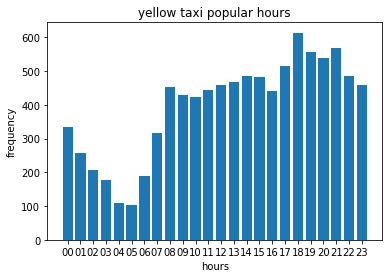

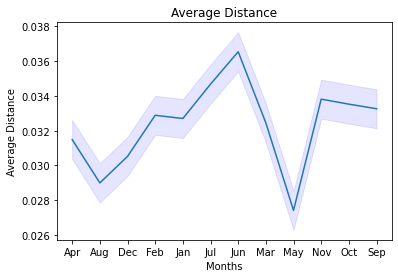

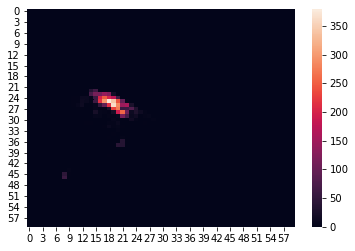

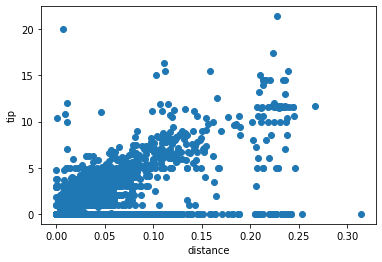

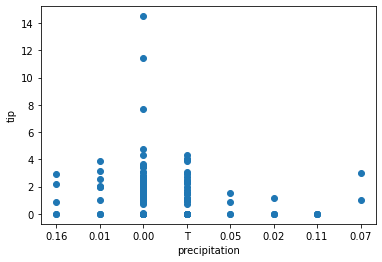

In [48]:
query1 = pd.read_sql_query (QUERY_1, connection)
query2 = pd.read_sql_query (SQLV2, connection)
query4 = pd.concat([df1,df2])
query5 = df3
query6 = merged[["precipitation","tip_amount"]]
query6 = query6.dropna()

#plot_visual_n(some_dataframe)
yellow_taxi_popular_hour(query1)
average_distance_traveled(query2)
heatmap(query4)
tip_and_distance(query5)
tip_and_precipitation(query6)

In [49]:
#3 Questions:

# Is the tip amount correlated with windspeed? Create a visualisation
# Which day of the week is uber more popular than Yellow taxi? Create a scatterplot
#Which day of the week are riders the most genereous? Create a visualisation